# Networking for Big Data - Project
- Jonas Barth 2050678
- Susanna Bravi 1916681
- Eric Rubia Aguilera 2049558

# Part A
#### 1. Extract general info from your trace using capinfos

In [1]:
!capinfos -A _00000_20190410070000.pcap

capinfos: The file "_00000_20190410070000.pcap" doesn't exist.


#### 2. Time Evaluation between Sequential and Parallel reading

#### 3. Extract the IP which generates the highest amount as sender traffic, evaluate the bit rate (0.1 sec) for the 6 IP addresses mostly used as endpoint


In [1]:
import pyshark
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy
import sys
import shutil
import os
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")


In [2]:
# It takes about 2 minutes (or more) to import the pkl file
dataFrame = pd.read_feather("packets.feather")
len(dataFrame)

832768

In [166]:
#dataFrame.head()
source = dataFrame.groupby(["IP_SRC"])
len(source) #we have 4548 different sources
# what is the source that sends more pckts?

4548

In [167]:
data_couple = dataFrame.groupby(["IP_SRC"])[['length']].agg('sum')
print(data_couple.sort_values(by=['length'], ascending=False).head(10))

                    length
IP_SRC                    
150.57.136.251   646286708
203.122.131.143   49658173
202.7.174.242     39305437
150.57.242.48     32295298
203.122.136.47    18161035
133.245.254.6      9544392
104.83.4.164       6484814
104.83.4.148       6141550
74.126.15.88       5142417
211.178.7.4        4344698


In [168]:
max = data_couple.max()
print(data_couple.loc[data_couple['length'] == int(max.iloc[0])])
#so maybe the ip source that generates more traffic is 150.57.136.251

                   length
IP_SRC                   
150.57.136.251  646286708


In [169]:
onlyTheSource = dataFrame[dataFrame["IP_SRC"] == "150.57.136.251"]

data_destination = onlyTheSource.groupby(["IP_DST"])[['length']].agg('sum').sort_values(by=['length'], ascending=False).head(6)

data_6IPs = onlyTheSource.groupby(["IP_DST"])
print(data_destination)

rowlength = int(data_destination.shape[0]/2)


                   length
IP_DST                   
222.127.201.52   56008928
115.181.56.11    36184278
66.132.46.70     34728784
221.246.5.50     32522020
221.244.225.179  23983685
153.153.206.192  23250986


In [170]:
fig = px.histogram(dataFrame["length"], x='length',
                   nbins=15, 
                   title='Histogram of Packet Length',
                   labels={'length':'Packet Length (Byte)'},
                   opacity=0.8,
                   log_y=False,
                   color_discrete_sequence=['#2a9d8f'],
                   text_auto=True,
                   template='plotly_white',
                   width=800, 
                   height=400)
fig.update_layout(
    yaxis_title_text='Frequency',
    bargap=0.2, # gap between bars of adjacent location coordinates
    #margin=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="gray"
)
fig.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)
fig.show(renderer='notebook')

In [171]:
def bitRate(data, step_sec = 0.1):
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    #print("Start: ",start)
    #print("Finish: ",finish)
    
    
    data["time"] -= data.iloc[0]["time"]
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    
    #print("Start: ",start)
    #print("Finish: ",finish)
    
    step = finish/ step_sec
    finish = start + step_sec
    value = []
    #print(step)
    for i in range(int(step)):
    
        #From Byte to bit - selection of the time interval between the start and the end of a single time slot
        val = np.sum(data[(data["time"]>=start) & (data["time"]<finish)]["length"]*8)
        if not np.isnan(val):
            value.append(val/step_sec)
        start = finish 
        finish = start + step_sec
        
    return value


222.127.201.52
115.181.56.11
66.132.46.70
221.246.5.50
221.244.225.179
153.153.206.192


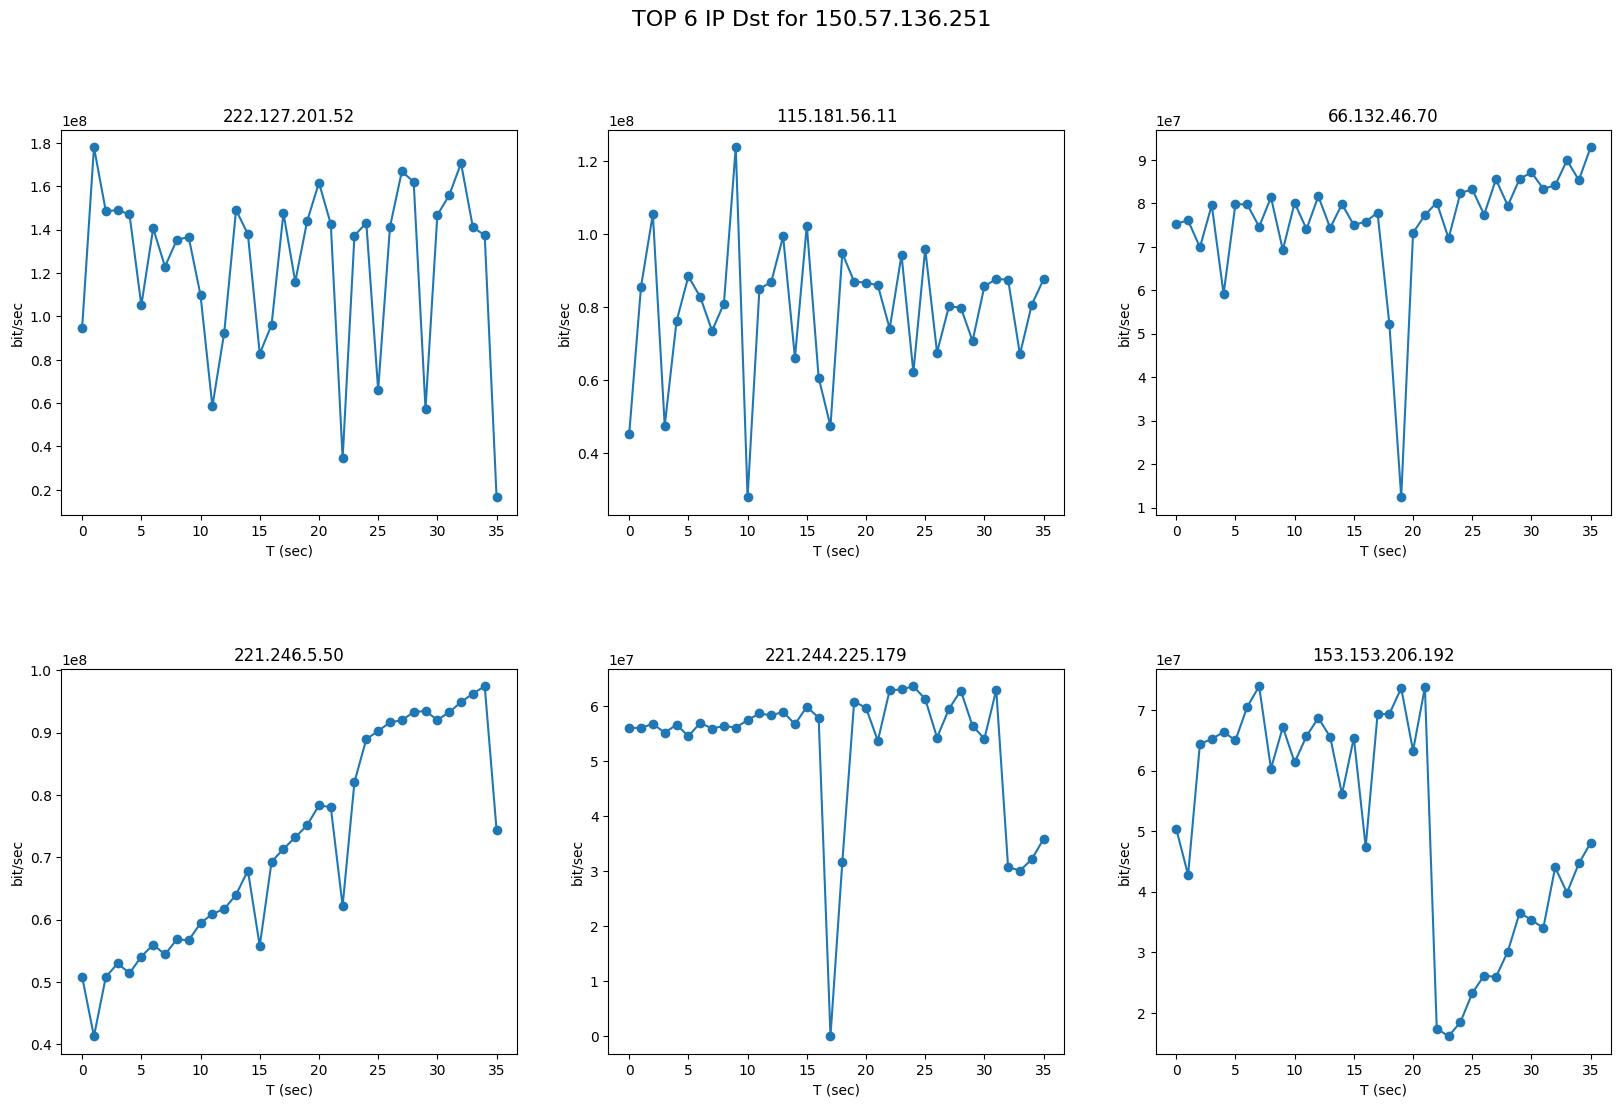

In [199]:
fig, axs = plt.subplots(figsize=(20,12), 
                        nrows=2, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 
#fig.tight_layout()
targets = zip(data_destination.index, axs.flatten())
for i, (key, ax) in enumerate(targets):
    print(key)
    #ax.plot(data_couple.get_group(key)["length"])
    ax.plot(bitRate(data_6IPs.get_group(key)),marker = "o")
    ax.set_title(key)
    ax.set_xlabel("T (sec)")
    ax.set_ylabel("bit/sec")
    #ax.set_yscale('log')
fig.suptitle('TOP 6 IP Dst for 150.57.136.251', fontsize=16)
#plt.savefig("TOP 6 IP Dst for MyIP")
plt.show()

#If now the step in bit rate is 0.1 second, the label of the x axes remains in seconds?

#### 4. Top 5 Destination IP (received bytes) and Top 5 Source IP (sent bytes)


In [173]:
data_top5dest = dataFrame.groupby(["IP_DST"])[['length']].agg('sum').sort_values(by=['length'], ascending=False).head(5)
data_top5dest

length
IP_DST                  
222.127.201.52  56008928
115.181.56.11   36184278
66.132.46.70    34728784
221.246.5.50    32522020
221.5.73.197    32291317

In [174]:
bar_dest = px.bar(data_top5dest, y=data_top5dest.index[:], x = data_top5dest['length'][:]/1e3,
                    title='Top 5 destinations',
                    opacity=0.8,
                    color_discrete_sequence=['#e5b769'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)
bar_dest.update_layout(
    yaxis_title_text ='Destinations',
    xaxis_title_text ='Received Bytes')# gap between bars of adjacent location coordinates
bar_dest.update_yaxes(tickfont_family="Arial Black")
bar_dest.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)



In [175]:
data_top5source = data_couple.sort_values(by=['length'], ascending=False).head(5)

In [176]:
bar_source = px.bar(data_top5source, y=data_top5source.index[:], x = data_top5source['length'][:]/1e3,
                    title='Top 5 sources',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)
bar_source.update_layout(
    yaxis_title_text ='Sources',
    xaxis_title_text ='Bytes Sent')
bar_source.update_yaxes(tickfont_family="Arial Black")
bar_source.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

#### 5. Evaluate bitRate considering all the trace with 3 different sampling rate

In [132]:
bit_plot = px.line(dataFrame,
              x=[ i*0.1 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))))+1)],
              y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))),
              template='plotly_white',
              title='Total bit rate',
              markers=True)
bit_plot['data'][0]['showlegend'] = True
bit_plot['data'][0]['name'] = '0.1 sec'
bit_plot.add_scatter(x=[ i*0.4 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.4))))+1)], 
                y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.4))),name="0.4 sec")
bit_plot.add_scatter(x=[ i*0.8 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.8))))+1)], 
                y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.8))),name="0.8 sec")
bit_plot.update_layout(
    yaxis_title_text ='Mbps',
    xaxis_title_text ='Time(s)')


NameError: name 'bitRate' is not defined

#### 6. GeoLocal Referenciation of the 5 sessions with the highest amount of traffic generated

In [178]:
from ip2geotools.databases.noncommercial import DbIpCity
import folium

In [179]:
def geo_infos(ip_src_list, ip_dst_list):

  src_geo_info = []
  dst_geo_info = []
  i = 0

  for j in range(len(ip_src_list)):
    try:
      src_response = DbIpCity.get(ip_src_list[j], api_key='free')
      dst_response = DbIpCity.get(ip_dst_list[j], api_key='free')
    except:
      continue
    if src_response.latitude == None or dst_response.latitude == None: 
      continue
    i +=1
    src_geo_info.append([src_response.latitude, src_response.longitude, src_response.region])
    dst_geo_info.append([dst_response.latitude, dst_response.longitude, dst_response.region])
    if i == 10: break

  return src_geo_info, dst_geo_info


In [180]:
data_couple = copy.deepcopy(dataFrame)
#Change your local IP with the one used to navigate on the Web
#data_couple["IP_SRC"]= data_couple["IP_SRC"].replace({'192.168.43.28':'46.37.14.27'})
#data_couple["IP_DST"] = data_couple["IP_DST"].replace({'192.168.43.28':'46.37.14.27'})
df_srcdst = list(zip(data_couple.IP_SRC, data_couple.IP_DST))

mostcommon_srcdst = Counter(df_srcdst).most_common(5)
mostcommon_srcdst

[(('172.201.24.110', '131.137.54.7'), 53309),
 (('172.201.24.79', '131.137.37.197'), 30821),
 (('150.57.136.251', '222.127.201.52'), 25608),
 (('150.57.136.251', '221.246.5.50'), 20599),
 (('150.57.136.251', '66.132.46.70'), 16946)]

In [181]:
list_src = []
list_dst = []

for i in range(len(mostcommon_srcdst)):
    list_src.append(mostcommon_srcdst[i][0][0]) #src pos 0
    list_dst.append(mostcommon_srcdst[i][0][1]) #dst pos 1

#src_geo, dst_geo = geo_infos(list(top_10_flows['ip_src']), list(top_10_flows['ip_dst']))

#Sigle Couple
#src_geo, dst_geo = geo_infos(['185.86.84.30'],['46.37.14.27'])
#5 Couples
src_geo, dst_geo = geo_infos(list_src, list_dst)

src_geo = pd.DataFrame(src_geo, columns=['latitude', 'longitude', 'region'])
dst_geo = pd.DataFrame(dst_geo, columns=['latitude', 'longitude', 'region'])

print("Data:  \n")
print(src_geo)
print()
print(dst_geo)
print("\n")

flow_map = folium.Map([0, 0], zoom_start=2, tiles='Stamen Terrain')

for i in range(len(src_geo)):
  folium.Marker([src_geo.loc[i][0], src_geo.loc[i][1]], popup='<i>Mt. Hood Meadows</i>', 
                icon=folium.Icon(color='green')).add_to(flow_map)
  folium.Marker([dst_geo.loc[i][0], dst_geo.loc[i][1]], popup='<i>Mt. Hood Meadows</i>',  
                icon=folium.Icon(color='red')).add_to(flow_map)
  folium.PolyLine([(src_geo.loc[i][0], src_geo.loc[i][1]), (dst_geo.loc[i][0], dst_geo.loc[i][1])], 
                  color="blue", weight=1.5, opacity=1).add_to(flow_map)

#flow_map.save(folder_image +"Map_top_5_flows.html")
#display(flow_map)

Data:  

    latitude   longitude   region
0  51.507336   -0.127650  England
1  51.507336   -0.127650  England
2  35.693810  139.753216    Tokyo
3  35.693810  139.753216    Tokyo
4  35.693810  139.753216    Tokyo

    latitude   longitude                   region
0  45.428475  -75.676440                  Ontario
1  45.428475  -75.676440                  Ontario
2  14.527054  121.074494  National Capital Region
3  35.693810  139.753216                    Tokyo
4  40.886016  -74.007257               New Jersey




#### 7. 10 Protocol mostly used

In [73]:
grouped_flows = dataFrame.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
print(grouped_flows)

              IP_SRC           IP_DST  Protocol  src_port  dst_port  tot_len
0       1.33.128.154  203.122.128.169        17       634       123       76
1          10.0.0.31   202.239.228.38        17     57970        53       65
2       10.1.200.200   202.239.228.38        17     58089        53       68
3           10.1.6.2   202.239.228.38         1        -1        -1      224
4        10.10.230.1   202.239.228.38        17     42070        53       57
...              ...              ...       ...       ...       ...      ...
31437  96.226.38.235    131.137.9.254        17        53     63533      141
31438  96.226.38.235    131.137.9.254        17        53     63677       95
31439  96.226.38.235    131.137.9.254        17        53     64459       95
31440  96.226.38.235    131.137.9.254        17        53     65472      100
31441  96.226.38.235  133.245.253.247        17        53     62569       98

[31442 rows x 6 columns]


In [74]:
grouped_flows.Protocol.value_counts().index #we have only 9 protocols??

Index([6, 1, 17, 50, 4, 47, 89, 97, 103], dtype='int64', name='Protocol')

In [75]:
grouped_flows["Protocol"] = grouped_flows["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP",50:"ESP",4:"IPv4",47:"GRE",89:"OSPFIGP",97:"ETHERIP",103:"PIM"}) 
#like this util we do not found the name of the other protocols
#found them in https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

In [76]:
bar_protocol = px.bar(grouped_flows["Protocol"], y=grouped_flows.Protocol.value_counts().index, x = grouped_flows.Protocol.value_counts().values,
                    title='Top 9 Protocols used',
                    opacity=0.8,
                    color_discrete_sequence=['#2a9d8f'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)

bar_protocol.update_layout(
    yaxis_title_text ='Prtocols',
    xaxis_title_text ='Count')
bar_protocol.update_yaxes(tickfont_family="Arial Black")
bar_protocol.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

### 8. Port Scanner evaluation (10 Ports mostly used)

In [11]:
def port_scan (x, dic):
    ''' scan through the ports and update the counter at each import file. 
    save only the info for the well-known ports '''
    for port in x:
        if pd.isnull(port) == False:
            #Well-Known Ports
            if int(port) < 1024:
                if port not in dic.keys():
                    dic[port] = 1
                else:
                    dic[port] += 1
    return(dic)

In [12]:
#Scanning port analysing pandasDataframe, both for source and destination ports
source_ports = {}
source_ports = port_scan(dataFrame["src_port"], source_ports)
dest_ports = {}
dest_ports = port_scan(dataFrame["dst_port"], dest_ports)

pd.DataFrame.from_dict(source_ports, orient = 'index').to_json('./source_ports.json')
pd.DataFrame.from_dict(dest_ports, orient = 'index').to_json('./dest_ports.json')

sports = pd.read_json('./source_ports.json')
dports = pd.read_json('./dest_ports.json')

sports = sports.reset_index()
dports = dports.reset_index()
sports = sports.rename(columns = {'index':'port', 0:'count'})
dports = dports.rename(columns = {'index':'port', 0:'count'})

sports = sports.sort_values(by = 'count', ascending = False)
dports = dports.sort_values(by = 'count', ascending = False)

In [40]:
aux=dataFrame[dataFrame['dst_port']==-1]
aux=aux[aux['Protocol']==17]
#aux

# We observe that these pkts have a defult -1 for source and destination number since they seem to be related to
#control rather than to messages, but there are some UDP pkts... weirddddddo

In [13]:
#PROBLEM ?
dports.port.value_counts().index #who is -1 ???

Index([443, 995,  90,   7, 137, 139,   1, 634, 771,  80, 789,  81,  89, 890,
       385, 990, 143, 179,  43, 445, 587,  23, 110, 500,  21, 123,  25, 161,
        22, 993, 873,  53,  -1, 124],
      dtype='int64', name='port')

In [32]:
#dports['port']=dports['port'].astype('string')
dports_10 = dports.sort_values(by=['count'], ascending=False).head(10)
dports_10["port"] = dports_10["port"].replace({443:"443 - HTTPS",80:"80 - HTTP",-1:"-1 - ICMP",53:"53 - DNS",873:"873 - rsync",993:"993 - IMAP4",22:"22 -SSH",161:"161 - SNMP ",25:"25 - SMTP",123:"123 - NTP"}) 
#sports['port']=sports['port'].astype('string')
sports_10 = sports.sort_values(by=['count'], ascending=False).head(10)
sports_10["port"] = sports_10["port"].replace({443:"443 - HTTPS",80:"80 - HTTP",-1:"-1 - ICMP",53:"53 - DNS",873:"873 - rsync",993:"993 - IMAP4",22:"22 -SSH",161:"161 - SNMP ",25:"25 - SMTP",123:"123 - NTP"}) 

In [33]:
port_plot = px.bar(dports_10,x=dports_10['port'],y=dports_10['count'],text_auto=True,
                    title='Top 10 Destination ports used',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    template='plotly_white',
                    width=800, 
                    height=400)
'''
port_plot.update_layout(
    yaxis_title_text ='Ports',
    xaxis_title_text ='Count')
port_plot.update_xaxes(tickfont_family="Arial Black")
port_plot.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)'''

'\nport_plot.update_layout(\n    yaxis_title_text =\'Ports\',\n    xaxis_title_text =\'Count\')\nport_plot.update_xaxes(tickfont_family="Arial Black")\nport_plot.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)'

In [34]:
sport_plot = px.bar(sports_10,x=sports_10['port'],y=sports_10['count'],text_auto=True,
                    title='Top 10 Source ports used',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    template='plotly_white',
                    width=800, 
                    height=400)
'''
sport_plot.update_layout(
    yaxis_title_text ='Ports',
    xaxis_title_text ='Count')
sport_plot.update_xaxes(tickfont_family="Arial Black")
sport_plot.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)'''

'\nsport_plot.update_layout(\n    yaxis_title_text =\'Ports\',\n    xaxis_title_text =\'Count\')\nsport_plot.update_xaxes(tickfont_family="Arial Black")\nsport_plot.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)'

In [35]:
#maybe we prefer them together?
fig = make_subplots(rows=1, cols=2,subplot_titles=("Destination Ports", "Source Ports"),shared_yaxes=True)
fig.add_trace(port_plot['data'][0], row=1, col=1)
fig.add_trace(sport_plot['data'][0], row=1, col=2)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="10 most used ports",
    xaxis_title_text ='Ports',
    yaxis_title_text ='Count')
fig.update_layout(template='plotly_white')
fig.update_xaxes(tickfont_family="Arial Black")
fig.update_xaxes(title_text="ports", row=1, col=2)
fig.update_yaxes(title_text="count", row=1, col=2)
fig.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

### 9. InterArrival Time boxplot between TCP and UDP Sessions

In [43]:
import copy
from collections import Counter

def InterArrivalTime(data):
    val = np.array(data["time"])
    #Calculate the n-th discrete difference along the given axis
    return np.diff(val)

data_protocol = copy.deepcopy(dataFrame[dataFrame["Protocol"].isin([6,17])])
data_protocol["Protocol"] = data_protocol["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP"})

print(Counter(data_protocol["Protocol"]))

Counter({'TCP': 790693, 'UDP': 30909})


In [44]:
box_len = px.box(data_protocol, y="length", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#Seems like we have small pkts
#From the histogram at the beginning of the document we can see that almost all the pkts are < 2000 byte
#Let's try to do for only pkts of this size

In [45]:
data_protocol_2000 = data_protocol[data_protocol["length"]<= 2000]
box_len_2000 = px.box(data_protocol_2000, y="length", x='Protocol', color='Protocol',template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
# The TCP box is quite big so the interquantile range is large... so we have data that is quite variable
# The UDP's box is smaller that the TCP one so here the variance is smaller and also the size of the pckts is smaller that the TCP. UDP also does not have pckts pf size bigger that 1500 byte while TCP has
# a median equal to 1299 so the 50% of the pckts are bigger taht 1300 bytes.

In [46]:
np.quantile(np.array(data_protocol['length']),q=0.88)

2148.0

In [ ]:
fig = make_subplots(rows=1, cols=4,subplot_titles=("Original data UDP","Original data TCP", "Pckts whit length < 2000 bytes UDP","Pckts whit length < 2000 bytes TCP"))
fig.add_trace(box_len['data'][0], row=1, col=1)
fig.add_trace(box_len['data'][1], row=1, col=2)
fig.add_trace(box_len_2000['data'][0], row=1, col=3)
fig.add_trace(box_len_2000['data'][1], row=1, col=4)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="Packets length")
fig.update_layout(template='plotly_white',showlegend=False)

In [48]:
soloUDP = data_protocol[data_protocol["Protocol"]=='UDP']
np.max(np.array(soloUDP['length']))
#no UDP pckts bigger than 1500 bytes.. 
#maybe we should know why from the theory? 

1500

In [49]:
#Inter arrival time
tcp_data = data_protocol_2000[data_protocol_2000["Protocol"]=="TCP"]
udp_data = data_protocol_2000[data_protocol_2000["Protocol"]=="UDP"]

inteArr_TCP= []
for elem in tcp_data.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']):
    #groupby tuple (key,dataframe)
    inteArr_TCP += InterArrivalTime(elem[1]).tolist()

inteArr_UDP = []
for elem in udp_data.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']):
    inteArr_UDP += InterArrivalTime(elem[1]).tolist()


val_ = inteArr_TCP + inteArr_UDP

label_TCP = [ "TCP" for i in range(len(inteArr_TCP))]
label_UDP =[ "UDP" for i in range(len(inteArr_UDP))]

lab_ = label_TCP + label_UDP

d = {'Protocol': lab_, 'IntArrTime': val_}
df = pd.DataFrame(data=d)

In [50]:
print("Mean InterArrivalTime TCP Session: %.4f"% np.mean(np.array(inteArr_TCP)))
print("Mean InterArrivalTime UDP Session: %.4f"% np.mean(np.array(inteArr_UDP)))
#the TCP interarrival time is smaller than the UDP
#median?
print("Median InterArrivalTime TCP Session: %.5f"% np.median(np.array(inteArr_TCP)))
print("Median InterArrivalTime UDP Session: %.5f"% np.median(np.array(inteArr_UDP)))
# 3rd quartile
print("3rd quartile InterArrivalTime TCP Session: %.5f"% np.quantile(np.array(inteArr_TCP),q=0.75))
print("3rd quartile InterArrivalTime UDP Session: %.5f"% np.quantile(np.array(inteArr_UDP),q=0.75))
#After this make sense to plot it for values less that 0.00004 (median of TCP) seconds and 0.0009 (median of UDP)

Mean InterArrivalTime TCP Session: 0.0087
Mean InterArrivalTime UDP Session: 0.0482
Median InterArrivalTime TCP Session: 0.00004
Median InterArrivalTime UDP Session: 0.00091
3rd quartile InterArrivalTime TCP Session: 0.00054
3rd quartile InterArrivalTime UDP Session: 0.01924


In [51]:
df1 = df[df["IntArrTime"] <  0.0009]
fig1 = px.box(df1, y="IntArrTime", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#fig.show()

In [52]:
df2 = df[df["IntArrTime"] < 0.00004]
fig2 = px.box(df2, y="IntArrTime", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=4,subplot_titles=("UDP < 0.009 s","TCP < 0.009 s", "UDP < 0.00004","TCP < 0.00004"))
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig1['data'][1], row=1, col=2)
fig.add_trace(fig2['data'][0], row=1, col=3)
fig.add_trace(fig2['data'][1], row=1, col=4)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="Interarrival time",
    yaxis_title_text='Time (s)')
fig.update_layout(template='plotly_white',showlegend=False)

### 10. Develope your own analysis (e.g. Topology of the network using networkx or evaluation about a variable such as TTL) 

In [3]:
import networkx as nx
import random
random.seed(26111998) # COMPLEANNO DI MAVI <3

In [45]:
Dest_IPs,Source_IPs=list(dataFrame['IP_DST']),list(dataFrame['IP_SRC'])
len(np.unique(Dest_IPs+Source_IPs))

18413

In [46]:
data_udp=dataFrame[dataFrame['Protocol']==17]
data_tcp=dataFrame[dataFrame['Protocol']==6]
data_ICMP=dataFrame[dataFrame['Protocol']==1]

In [47]:
Dest_IPs_UDP,Source_IPs_UDP=list(data_udp['IP_DST']),list(data_udp['IP_SRC'])
len(np.unique(Dest_IPs_UDP+Source_IPs_UDP))

4229

In [48]:
Dest_IPs_TCP,Source_IPs_TCP=list(data_tcp['IP_DST']),list(data_tcp['IP_SRC'])
len(np.unique(Dest_IPs_TCP+Source_IPs_TCP))

4660

In [49]:
Dest_IPs_ICMP,Source_IPs_ICMP=list(data_ICMP['IP_DST']),list(data_ICMP['IP_SRC'])
len(np.unique(Dest_IPs_ICMP+Source_IPs_ICMP))

10162

#### UDP GRAPH

In [50]:
data_udp=data_udp.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
data_udp.drop('tot_len',axis=1,inplace=True)
UDP=data_udp[['IP_SRC','IP_DST']]
udp_count=dict(UDP.value_counts())
l=[]
for i in range(len(data_udp)):
    l.append(udp_count[(data_udp.iloc[i]['IP_SRC'],data_udp.iloc[i]['IP_DST'])])
data_udp['Num Flows']=l
data_udp


IP_SRC           IP_DST  src_port  dst_port  Num Flows
0      1.33.128.154  203.122.128.169       634       123          1
1         10.0.0.31   202.239.228.38     57970        53          1
2      10.1.200.200   202.239.228.38     58089        53          1
3       10.10.230.1   202.239.228.38     42070        53          1
4       10.10.231.1   202.239.228.38     49760        53          1
...             ...              ...       ...       ...        ...
8971  96.226.38.235    131.137.9.254        53     63533         35
8972  96.226.38.235    131.137.9.254        53     63677         35
8973  96.226.38.235    131.137.9.254        53     64459         35
8974  96.226.38.235    131.137.9.254        53     65472         35
8975  96.226.38.235  133.245.253.247        53     62569          1

[8976 rows x 5 columns]

In [51]:
Graph_UDP=nx.DiGraph()

for _,i in data_udp.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_UDP.edges:
        Graph_UDP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_UDP.add_edge(node_a,node_b)
        Graph_UDP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_UDP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

In [21]:
#Graph_UDP.get_edge_data("96.226.38.235","131.137.9.254")
#np.unique([i[0] for i in Graph_UDP.get_edge_data("96.226.38.235","131.137.9.254")['List']])
# Runnare per vedere un essempio dei attributi dell'arco

#### TCP GRAPH

In [101]:
data_tcp=data_tcp.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
data_tcp.drop('tot_len',axis=1,inplace=True)
TCP=data_tcp[['IP_SRC','IP_DST']]
tcp_count=dict(TCP.value_counts())
l=[]
for i in range(len(data_tcp)):
    l.append(tcp_count[(data_tcp.iloc[i]['IP_SRC'],data_tcp.iloc[i]['IP_DST'])])
data_tcp['Num Flows']=l
data_tcp


IP_SRC           IP_DST  src_port  dst_port  Num Flows
0      101.109.179.209  133.227.248.213     62305        80          1
1        103.16.151.16     202.9.10.149     20122      8080          1
2        103.244.59.90   202.239.228.38     37795        53          1
3        103.248.96.53      202.9.24.22     49586       445          1
4        103.92.30.151   131.137.220.31       443     64179          2
...                ...              ...       ...       ...        ...
11825    90.157.122.20   202.239.228.38     49865        53          9
11826    90.157.122.20   202.239.228.38     55372        53          9
11827    90.157.122.20   202.239.228.38     59759        53          9
11828    90.157.122.20   202.239.228.38     60134        53          9
11829     95.36.218.85      202.9.24.18     48187        23          1

[11830 rows x 5 columns]

In [102]:
Graph_TCP=nx.DiGraph()

for _,i in data_tcp.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_TCP.edges:
        Graph_TCP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_TCP.add_edge(node_a,node_b)
        Graph_TCP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_TCP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

In [103]:
Graph_TCP.get_edge_data("95.36.218.85","202.9.24.18")

{'Num Flow': 1, 'List': [(48187, 23)]}

#### ICMP GRAPH

In [110]:
data_ICMP=data_ICMP.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
data_ICMP.drop('tot_len',axis=1,inplace=True)
ICMP=data_ICMP[['IP_SRC','IP_DST']]
ICMP_count=dict(ICMP.value_counts())
l=[]
for i in range(len(data_ICMP)):
    l.append(ICMP_count[(data_ICMP.iloc[i]['IP_SRC'],data_ICMP.iloc[i]['IP_DST'])])
data_ICMP['Num Flows']=l
data_ICMP


IP_SRC           IP_DST  src_port  dst_port  Num Flows
0             10.1.6.2   202.239.228.38        -1        -1          1
1       101.103.70.215   203.122.146.18        -1        -1          1
2      101.108.198.211   203.122.146.18        -1        -1          1
3        103.105.44.95   203.122.146.18        -1        -1          1
4      103.223.193.204   203.122.146.18        -1        -1          1
...                ...              ...       ...       ...        ...
10610    8.247.137.248    150.57.226.71        -1        -1          1
10611    8.247.137.248   150.57.245.235        -1        -1          1
10612    8.247.137.248  203.122.132.249        -1        -1          1
10613    8.247.137.248  203.122.137.111        -1        -1          1
10614    8.247.137.248  203.122.137.140        -1        -1          1

[10615 rows x 5 columns]

In [111]:
Graph_ICMP=nx.DiGraph()

for _,i in data_ICMP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_ICMP.edges:
        Graph_ICMP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_ICMP.add_edge(node_a,node_b)
        #In this case we could simply go for a directed graph without attributes because the numflow is always 1 and the list is [-1,-1] for all
        Graph_ICMP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_ICMP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

In [112]:
Graph_ICMP.get_edge_data("8.247.137.248","203.122.132.249")

{'Num Flow': 1, 'List': [(-1, -1)]}

### Visualisation of the Graphs (Sample of the Data)

In [93]:
sample_UDP=data_udp.sample(600)
sample_UDP

IP_SRC           IP_DST  src_port  dst_port  Num Flows
3825   172.201.25.115   131.137.220.64       443     61311          1
7202  203.122.134.120   125.41.216.173        53     44307          1
5105  202.239.227.202  213.231.192.170        53     12041          2
1808      14.96.49.25   150.57.141.105        53     46723          1
1372  133.235.207.181   192.95.111.233     58094        53          2
...               ...              ...       ...       ...        ...
8170  216.116.245.140   131.137.98.174       443     47356          3
1281   133.226.13.230  193.167.130.230     63298        53          5
4548     202.1.190.11  193.167.130.230     51694        53          2
2390     150.57.15.83   74.126.195.117     65027       443          1
5843     202.9.53.195    45.159.174.80      2080        53         27

[600 rows x 5 columns]

In [94]:
Graph_subset_UDP=nx.DiGraph()

for _,i in sample_UDP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_UDP.edges:
        Graph_subset_UDP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_UDP.add_edge(node_a,node_b)
        Graph_subset_UDP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_UDP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

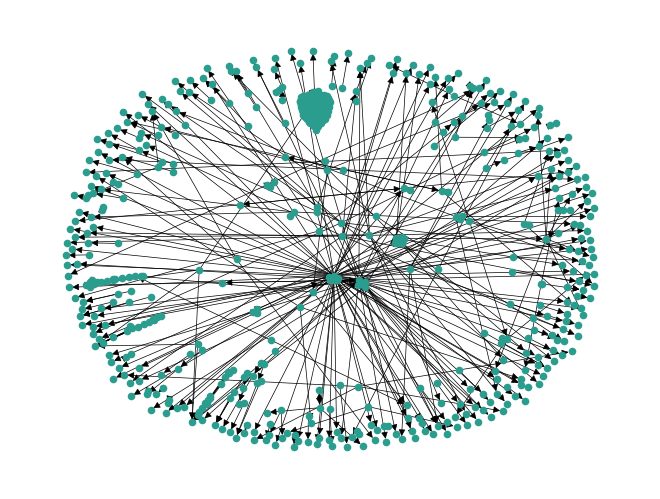

In [95]:
nx.draw(Graph_subset_UDP,node_size = 20, width = 0.5, node_color = '#2a9d8f')
#in this random sample we can see that there are few sources and lot of destinations

In [123]:
sample_TCP=data_tcp.sample(1000)
sample_TCP

IP_SRC           IP_DST  src_port  dst_port  Num Flows
5219    163.222.208.85    17.12.254.133     49863      5223          1
1915    150.57.136.251    106.65.74.199        80     33068         10
1159   133.245.198.254      182.166.8.1     57068       443          6
9193     202.7.174.242   52.199.120.200     62015       443          2
4203   163.222.124.247    108.65.110.64     58750      5228          1
...                ...              ...       ...       ...        ...
9443      202.7.174.40    172.201.24.68     45238       443         15
901     133.245.171.17   107.187.50.240     63011       443          1
8734     202.7.174.242  203.151.103.100     58698     10006          3
10916  216.116.245.139  131.137.243.202       443     58174          1
6588    172.201.25.126  131.137.183.191       443     53605          1

[1000 rows x 5 columns]

In [124]:
Graph_subset_TCP=nx.DiGraph()

for _,i in sample_TCP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_TCP.edges:
        Graph_subset_TCP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_TCP.add_edge(node_a,node_b)
        Graph_subset_TCP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_TCP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

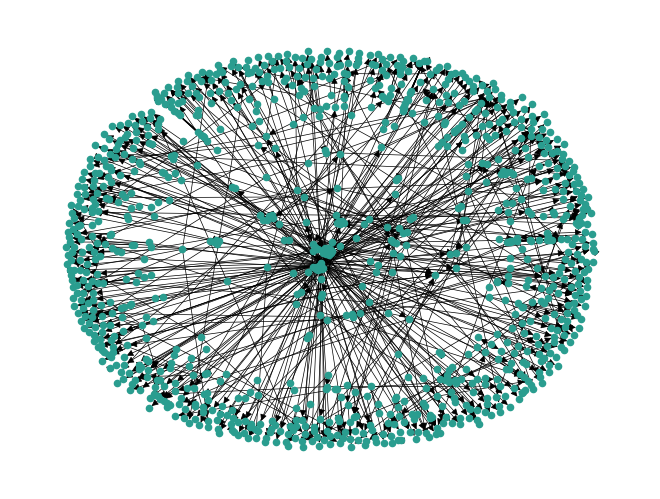

In [125]:
nx.draw(Graph_subset_TCP,node_size = 20, width = 0.5, node_color = '#2a9d8f')

In [129]:
sample_ICMP=data_ICMP.sample(500)
sample_ICMP

IP_SRC           IP_DST  src_port  dst_port  Num Flows
5459  203.122.146.18    175.150.113.8        -1        -1          1
1528  203.122.146.18    112.208.71.47        -1        -1          1
7416  203.122.146.18  221.247.166.235        -1        -1          1
6538  203.122.146.18   202.30.210.182        -1        -1          1
8277  203.122.146.18   39.131.103.212        -1        -1          1
...              ...              ...       ...       ...        ...
1783  203.122.146.18   114.142.103.47        -1        -1          1
3078  203.122.146.18    121.253.33.30        -1        -1          1
5197  203.122.146.18   171.229.74.131        -1        -1          1
5776  203.122.146.18  180.243.155.250        -1        -1          1
4730  203.122.146.18   153.194.10.125        -1        -1          1

[500 rows x 5 columns]

In [130]:
Graph_subset_ICMP=nx.DiGraph()

for _,i in sample_ICMP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_ICMP.edges:
        Graph_subset_ICMP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_ICMP.add_edge(node_a,node_b)
        Graph_subset_ICMP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_ICMP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

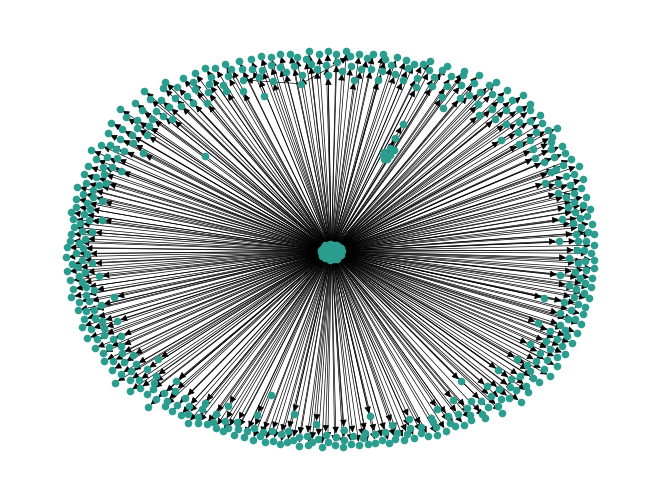

In [131]:
nx.draw(Graph_subset_ICMP,node_size = 20, width = 0.5, node_color = '#2a9d8f')

After this overview of the topology we have decided to put together the TCP and UDP graphs, while the ICMP graph has a particular topology with fewer sources and more destinations than the other two mentioned protocols. <br>
This is beacause the ICMP protocol is used for troubleshooting, the sources want to know if the destinations are reacheable.

In [18]:
#So let's merge them
data_transport=dataFrame[(dataFrame['Protocol']==17) | (dataFrame['Protocol']==6)]


In [147]:
Dest_IPs_t,Source_IPs_t=list(data_transport['IP_DST']),list(data_transport['IP_SRC'])
len(np.unique(Dest_IPs_t+Source_IPs_t))

8384

In [19]:
data_transport

Label DSCP  header len  ds_field ds_field_ecn  length  Protocol  \
0               0          20         0            0      95        17   
1               0          20         0            0    1420         6   
2               0          20         0            0      52         6   
3               0          20         0            0      52         6   
4               0          20         0            0     141        17   
...           ...         ...       ...          ...     ...       ...   
832763          0          20         0            0    1454         6   
832764          0          20         0            0    1500         6   
832765          0          20         0            0    1500         6   
832766          0          20         0            0    1500         6   
832767          0          20         0            0      40         6   

       flag_df flag_mf flag_rb fragment_offset  ttl           IP_SRC  \
0            1       0       0               0   57     23.53.35.140   
1            1       0       0               0   56   150.57.136.251   
2            0       0       0               0   54  180.213.208.201   
3            0       0       0               0   54  180.213.208.201   
4            0       0       0               0   58    150.57.190.76   
...        ...     ...     ...             ...  ...              ...   
832763       1       0       0               0   56   150.57.136.251   
832764       1       0       0               0   60   150.57.136.251   
832765       1       0       0               0   60   150.57.136.251   
832766       1       0       0               0   60   150.57.136.251   
832767       0       0       0               0  124   172.201.24.110   

                 IP_DST  src_port  dst_port          time  
0        131.137.126.25        53     48350  1.554872e+09  
1       221.244.225.179        80     64918  1.554872e+09  
2        203.122.136.47     53480        80  1.554872e+09  
3        203.122.136.47     53480        80  1.554872e+09  
4         155.70.48.196     50821     27023  1.554872e+09  
...                 ...       ...       ...           ...  
832763   222.127.201.52        80     62620  1.554872e+09  
832764     66.132.46.70       873      8878  1.554872e+09  
832765     66.132.46.70       873      8878  1.554872e+09  
832766     66.132.46.70       873      8878  1.554872e+09  
832767     131.137.54.7       443     52038  1.554872e+09  

[821602 rows x 16 columns]

In [20]:
data_transport = data_transport.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()

In [23]:
data_transport

IP_SRC           IP_DST  src_port  dst_port
0       1.33.128.154  203.122.128.169       634       123
1          10.0.0.31   202.239.228.38     57970        53
2       10.1.200.200   202.239.228.38     58089        53
3        10.10.230.1   202.239.228.38     42070        53
4        10.10.231.1   202.239.228.38     49760        53
...              ...              ...       ...       ...
20801  96.226.38.235    131.137.9.254        53     63533
20802  96.226.38.235    131.137.9.254        53     63677
20803  96.226.38.235    131.137.9.254        53     64459
20804  96.226.38.235    131.137.9.254        53     65472
20805  96.226.38.235  133.245.253.247        53     62569

[20806 rows x 4 columns]

In [22]:
data_transport = data_transport.drop('tot_len',axis=1,inplace=False)

In [24]:
TR=data_transport[['IP_SRC','IP_DST']]
t_count=dict(TR.value_counts())
l=[]
for i in range(len(data_transport)):
    l.append(t_count[(data_transport.iloc[i]['IP_SRC'],data_transport.iloc[i]['IP_DST'])])
data_transport['Num Flows']=l
data_transport

IP_SRC           IP_DST  src_port  dst_port  Num Flows
0       1.33.128.154  203.122.128.169       634       123          1
1          10.0.0.31   202.239.228.38     57970        53          1
2       10.1.200.200   202.239.228.38     58089        53          1
3        10.10.230.1   202.239.228.38     42070        53          1
4        10.10.231.1   202.239.228.38     49760        53          1
...              ...              ...       ...       ...        ...
20801  96.226.38.235    131.137.9.254        53     63533         35
20802  96.226.38.235    131.137.9.254        53     63677         35
20803  96.226.38.235    131.137.9.254        53     64459         35
20804  96.226.38.235    131.137.9.254        53     65472         35
20805  96.226.38.235  133.245.253.247        53     62569          1

[20806 rows x 5 columns]